(-0.5, 5279.5, 3955.5, -0.5)

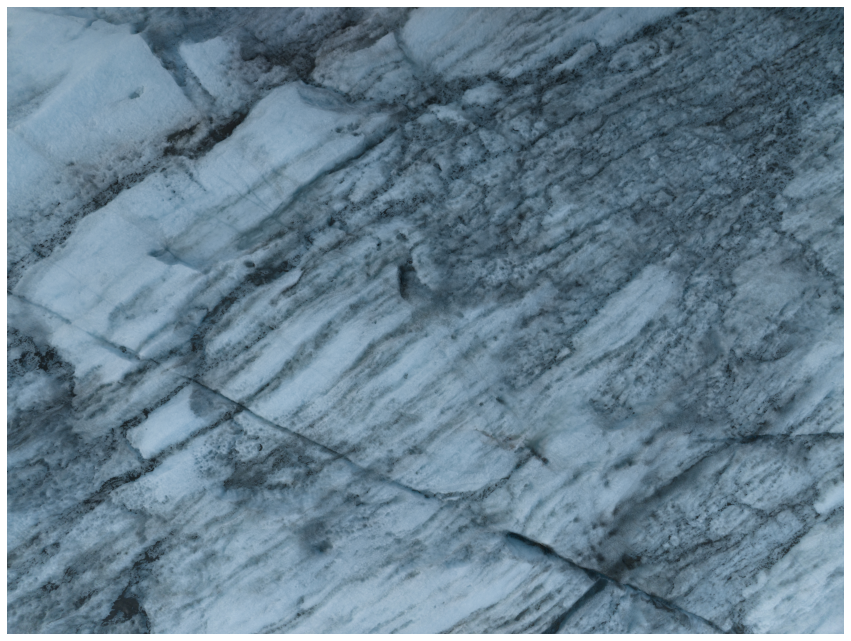

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]


image = Image.open('data/DJI_20230715091030_0013_D.jpg')
plt.imshow(image, cmap='Greys_r')
plt.axis('off')

# 1. Distribution of pixels

In [2]:
data = np.array(image, dtype=np.int32)
data_r, data_g, data_b = data[:, :, 0], data[:, :, 1], data[:, :, 2]

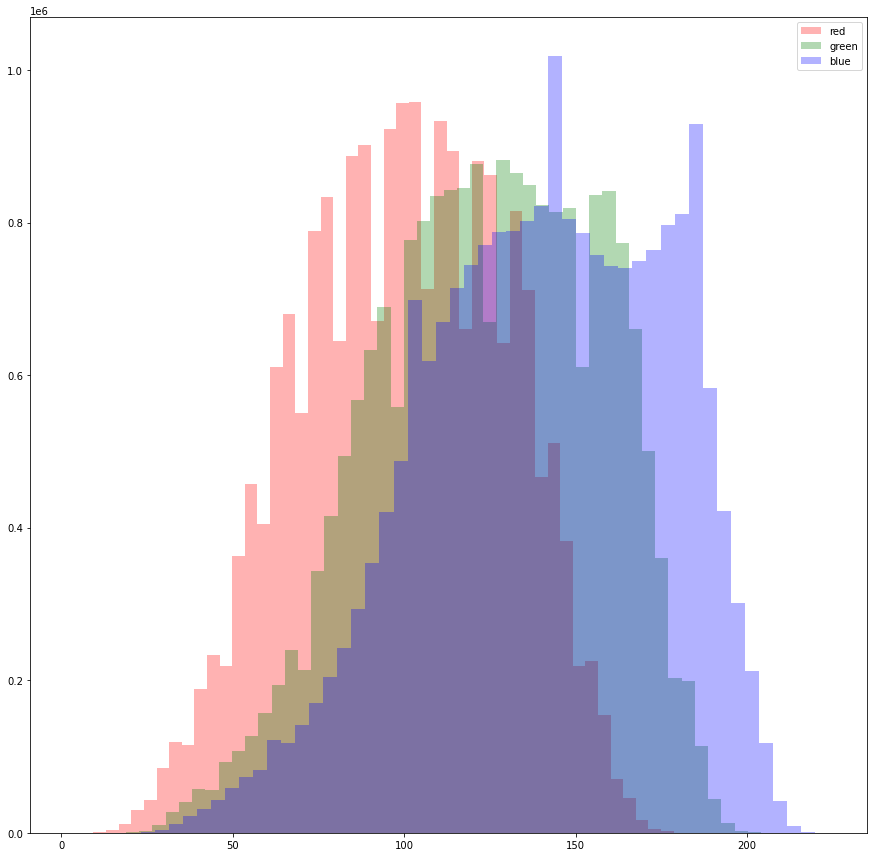

In [3]:
plt.hist(data_r.flatten(), label='red', color='red', alpha=0.3, bins=50)
plt.hist(data_g.flatten(), label='green', color='green', alpha=0.3, bins=50)
plt.hist(data_b.flatten(), label='blue', color='blue', alpha=0.3, bins=50)
plt.legend()

# 2. 2D Differential Entropy = delentropy

https://stats.stackexchange.com/questions/235270/entropy-of-an-image

https://arxiv.org/ftp/arxiv/papers/1609/1609.01117.pdf

https://gist.github.com/mxmlnkn/5a225478bc576044b035ad4a45c54f73

## 2.1 Definition

In [4]:
def deldensity(image):
    
    # differentiate
    fx = (image[:,2:] - image[:,:-2])[1:-1,:]
    fy = (image[2:,:] - image[:-2,:])[:,1:-1]
    
    # bin the gradient for faster computation
    diff_range = np.max([np.abs(fx.min()), np.abs(fx.max()), np.abs(fy.min()), np.abs(fy.max())])
    diff_range = 2**(int(np.log2(diff_range))+1) # always power of 2
    n_bins = min(1024, 2*diff_range+1)
    # Centering the bins is necessary because else all value will lie on
    # the bin edges thereby leading to assymetric artifacts
    dbin = 0.5
    r = diff_range + dbin
    delDensity, xedges, yedges = np.histogram2d(fx.flatten(), fy.flatten(), bins = n_bins, range = [[-r,r], [-r,r]])
    
    return delDensity, xedges, yedges

def H_image(image, plot=False):

    delDensity, xedges, yedges = deldensity(image)
    
    # compute entropy
    p = (delDensity / np.sum(delDensity)).T
    H = - 1/2 * np.sum(p[p.nonzero() ] * np.log2(p[p.nonzero()]))
    
    if plot:
        fig = plt.figure()
        ax = [
            fig.add_subplot(221, title = f"Original Image"),
            fig.add_subplot(222, title = "Gradient")
        ]
        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[1].imshow(delDensity, cmap=plt.cm.gray, vmin = 0, interpolation='nearest', origin='lower',
                extent = [ xedges[0], xedges[-1], yedges[0], yedges[-1]])
        fig.tight_layout()
        plt.show()
        
    return H

## 2.2. Comparing 2 images

More uniform image => Lower entropy

In [5]:
images = []

# pure noise
noise_8b = np.random.randint(low=0, high=255, size=data_r.shape)
images += [("Uniform random noise (8 bit)" , noise_8b)]

# Linear Gradients
hor_gradient = np.outer(np.ones(256), np.arange(256))
images += [("Horizontal Gradient", hor_gradient)]

# actual data
image_noisy, image_less_noisy = Image.open('data/noisy.jpg'), Image.open('data/less_noisy.jpg')
data_noisy, data_less_noisy = np.array(image_noisy, dtype=np.int32), np.array(image_less_noisy, dtype=np.int32)
data_noisy_r, data_less_noisy_r = data_noisy[:, :, 0], data_less_noisy[:, :, 0]
images += [("Noisy image", data_noisy_r)]
images += [("Less noisy image", data_less_noisy_r)]


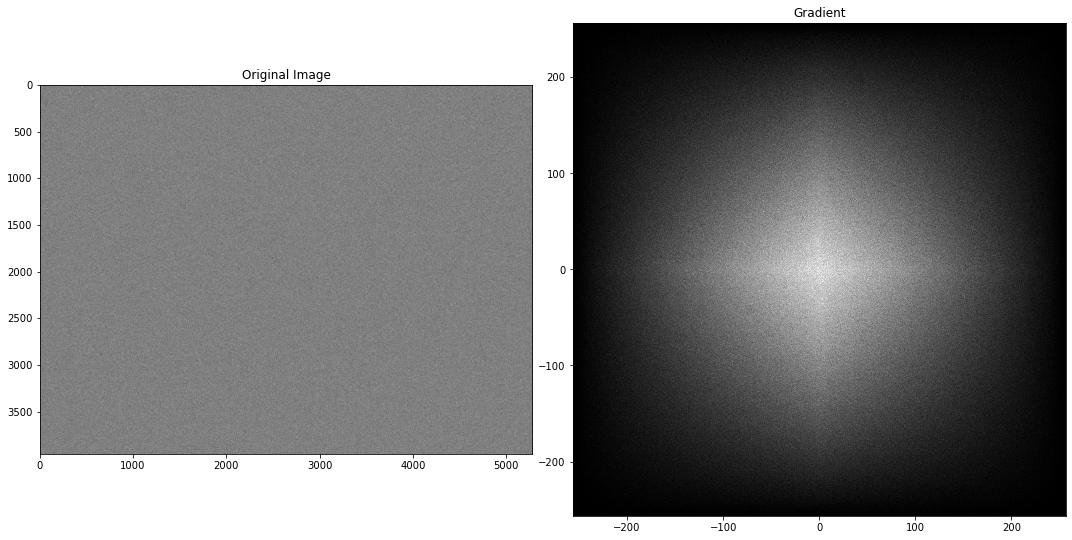

Uniform random noise (8 bit), H=8.711228183340026


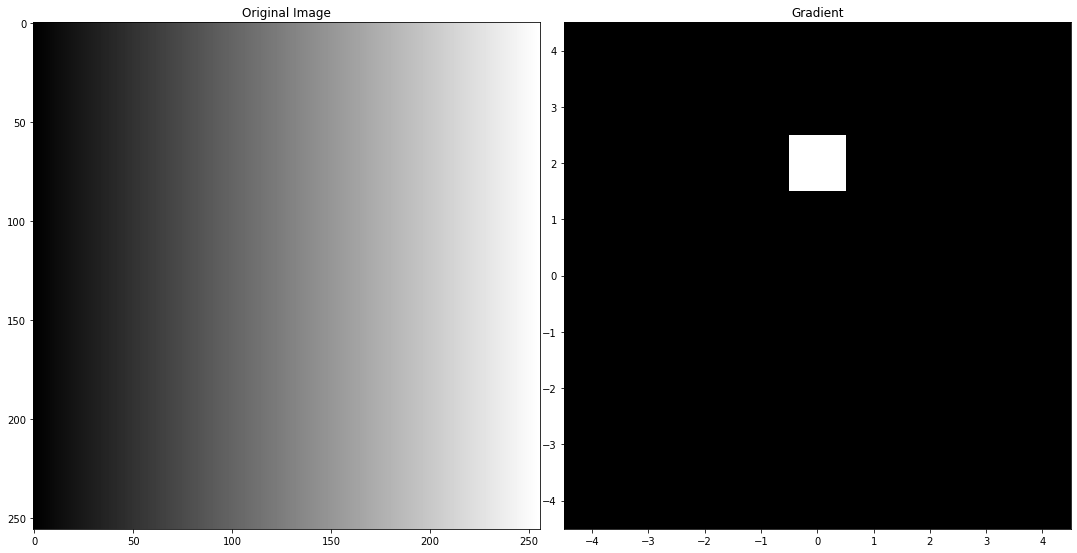

Horizontal Gradient, H=-0.0


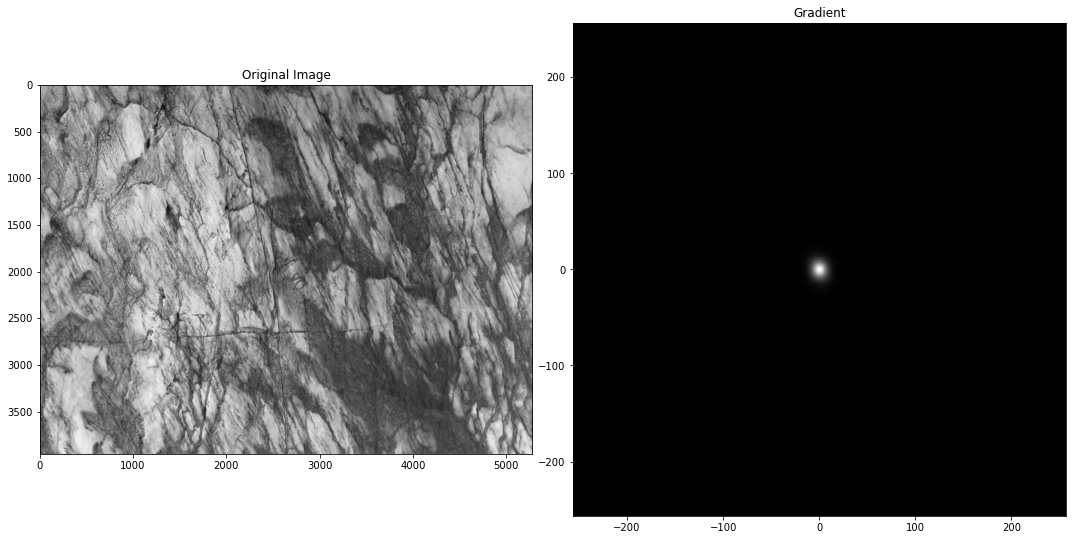

Noisy image, H=5.030086719686672


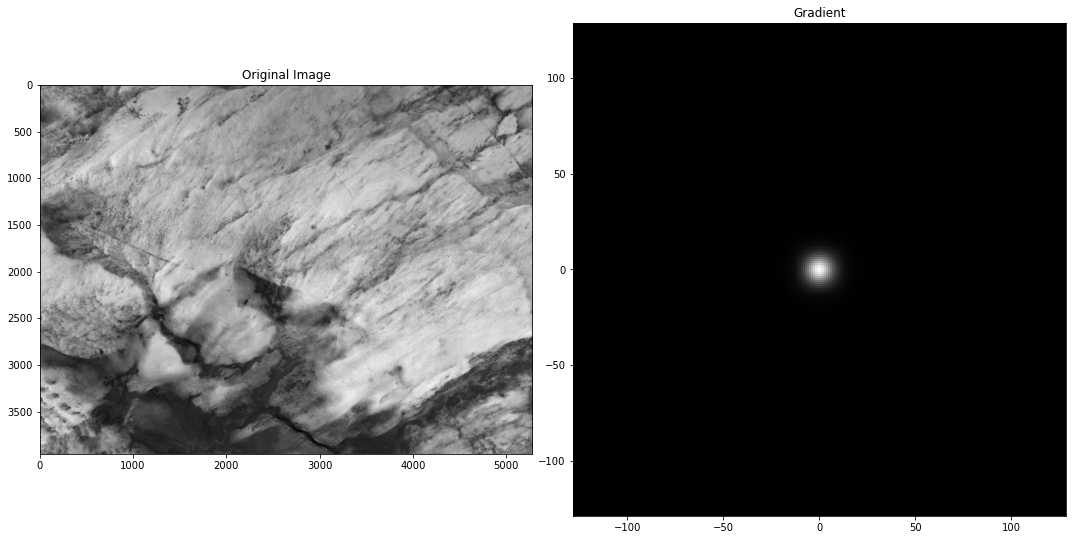

Less noisy image, H=4.703008083892738


In [6]:
for label, image in images:
    print(label + f', H={H_image(image, plot=True)}')

## 2.3. Image transposed, Image + noise, Image + blur

In [7]:
from scipy.signal import convolve2d

images = [("Original Image", data_r)]

# transposed image
images += [("Transposed Image", data_r.transpose())]

# add binomial noise
sigma = 20
data_r_noised = (data_r + np.random.normal(0, sigma, size=data_r.shape).astype(np.int32)).clip(0, 255)
images += [("Noised Image", data_r_noised)]

# blur by averaging close pixels
w = 20
window = np.ones(shape=(w, w)) / (w*w)
data_r_blurred = convolve2d(data_r, window, mode='same', boundary='wrap').astype(np.int32).clip(0, 255)
images += [("Blurred Image", data_r_blurred)]

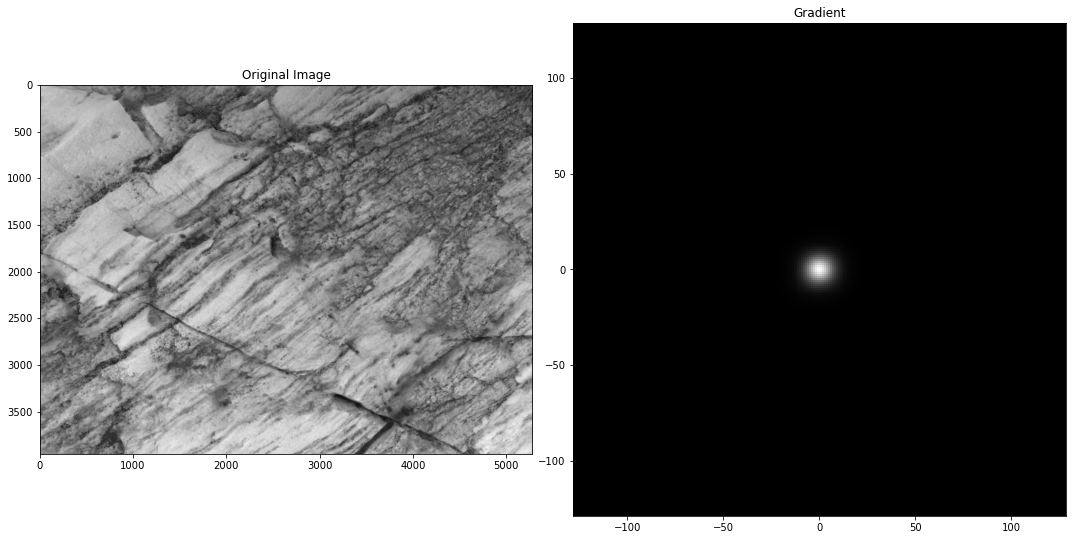

Original Image, H=4.702070499676816


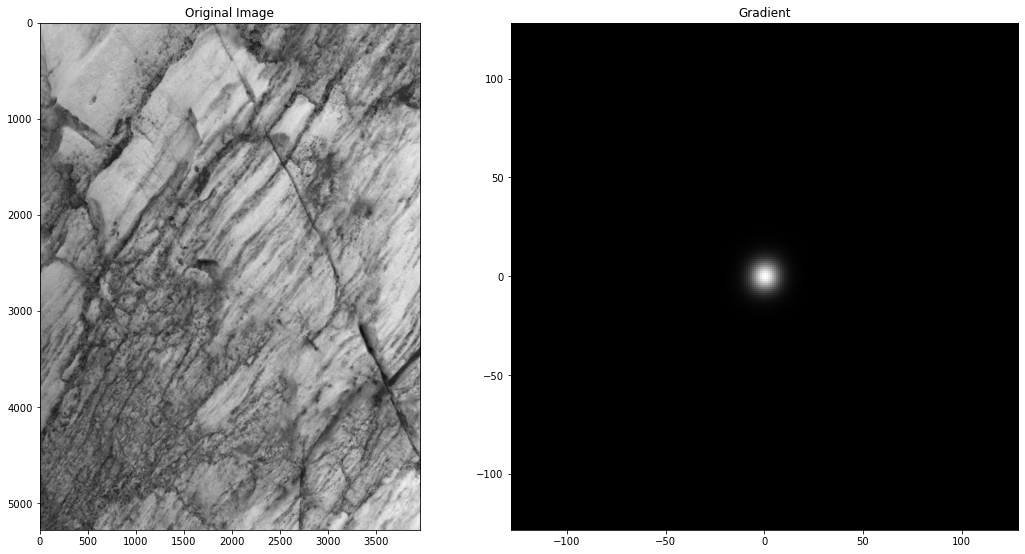

Transposed Image, H=4.702070499676817


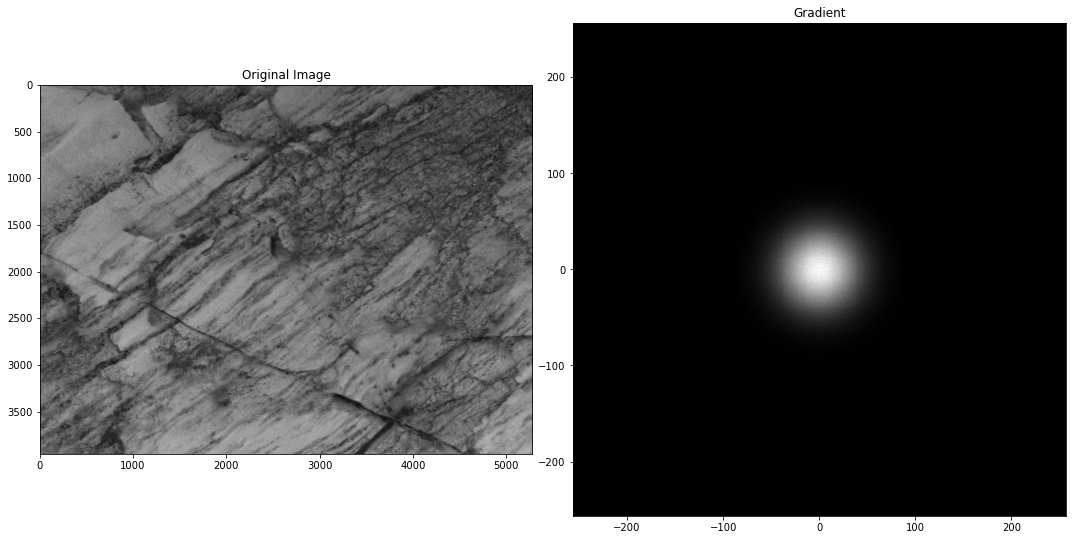

Noised Image, H=6.8769957843675655


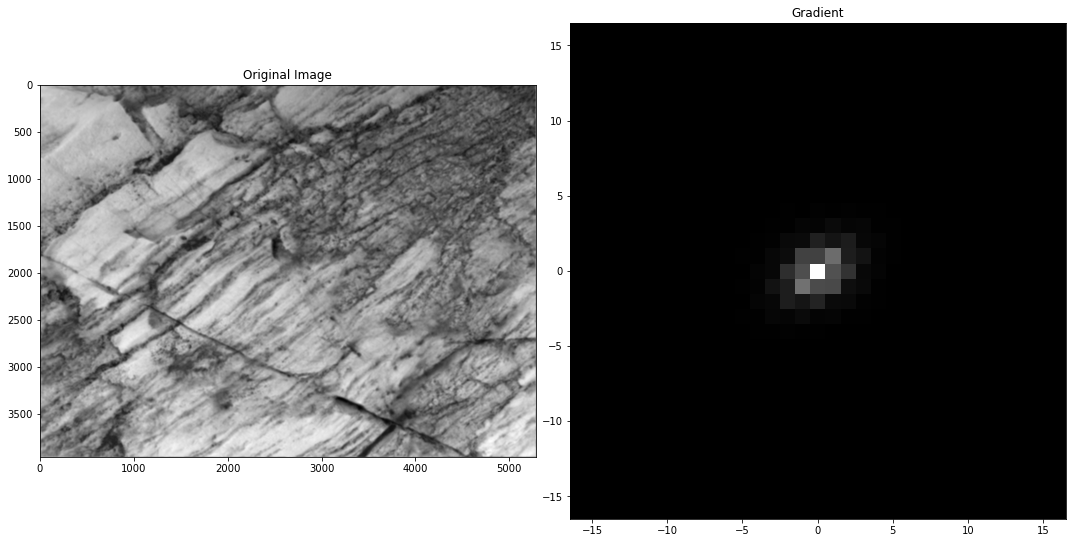

Blurred Image, H=2.521345935371339


In [8]:
for label, image in images:
    print(label + f', H={H_image(image, plot=True)}')

# 3. KL Divergence

In [9]:
def KL_image(image_1, image_2):
    eps = 1e-9
    
    # get the gradient distributions
    delDensity_1, _, _ = deldensity(image_1)
    p = delDensity_1.flatten()
    delDensity_2, _, _ = deldensity(image_2)
    q = delDensity_2.flatten()
    
    # if not the same size, sample the bigger
    if len(p) > len(q):
        p = np.random.choice(p, len(q))
    elif len(q) > len(p):
        q = np.random.choice(q, len(p))
        
    p = p / p.sum()
    q = q / q.sum()
        
    return (p * np.log2((p + eps) / (q + eps))).sum()
    

In [10]:
KL_image(data_r, data_r)

0.0

In [11]:
KL_image(data_r, data_r_blurred)

19.092158829490312

In [12]:
KL_image(data_r, data_r_noised)

17.968715005186613

In [13]:
KL_image(data_r, noise_8b)

7.747466824064612